In [1]:
!pip install torch torchvision opencv-python tqdm


**Imports**

In [14]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import UCF101
from torch.utils.data import DataLoader
from tqdm import tqdm


Importing the dataset

In [8]:
# Download UCF101 videos
!wget --no-check-certificate -O UCF101.rar https://www.crcv.ucf.edu/data/UCF101/UCF101.rar

# Download train/test split files
!wget --no-check-certificate -O UCF101TrainTestSplits.zip https://www.crcv.ucf.edu/data/UCF101/UCF101TrainTestSplits-RecognitionTask.zip


--2026-01-04 17:00:21--  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 6932971618 (6.5G) [application/x-rar-compressed]
Saving to: ‘UCF101.rar’

UCF101.rar           15%[==>                 ]   1.01G  14.9MB/s    in 75s     

2026-01-04 17:01:37 (13.8 MB/s) - Connection closed at byte 1085816355. Retrying.

--2026-01-04 17:01:38--  (try: 2)  https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 206 Partial Content
Length: 6932971618 (6.5G), 5847155263 (5.4G) remaining [application/x-rar-compressed]
Saving to: ‘UCF101.rar’

UCF101.rar           31%[+++==>            

In [9]:
!ls -lh


total 6.5G
drwxr-xr-x 1 root root 4.0K Dec  9 14:42 sample_data
-rw-r--r-- 1 root root 6.5G Nov 21  2012 UCF101.rar
-rw-r--r-- 1 root root 112K Oct 18  2013 UCF101TrainTestSplits.zip


In [10]:
!apt-get install unrar -y
!unrar x UCF101.rar
!unzip UCF101TrainTestSplits.zip


Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g09_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g09_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGu

Mounting the Drive here to save the model

In [11]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [16]:
!pip install av

In [18]:
# Install PyAV correctly
!apt-get update
!apt-get install -y ffmpeg
!pip install av --no-cache-dir


Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cli.github.com/packages stable/main amd64 Packages [345 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,227 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packa

In [19]:
import av
print("PyAV version:", av.__version__)


PyAV version: 16.0.1


In [21]:
from torchvision.datasets import UCF101


Dataset lOAD

In [26]:

class VideoDataset(Dataset):
    def __init__(self, root_dir, classes, frames_per_clip=16):
        self.samples = []
        self.frames_per_clip = frames_per_clip
        self.classes = classes
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224))
        ])

        for idx, cls in enumerate(classes):
            cls_folder = os.path.join(root_dir, cls)
            if not os.path.exists(cls_folder):
                continue
            for f in os.listdir(cls_folder):
                if f.endswith(".avi") or f.endswith(".mp4"):
                    self.samples.append((os.path.join(cls_folder, f), idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_path, label = self.samples[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.frames_per_clip:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(self.transform(frame))
        cap.release()
        # pad last frame if needed
        while len(frames) < self.frames_per_clip:
            frames.append(frames[-1])
        frames = torch.stack(frames)  # [T, C, H, W]
        return frames, label

### Using Three classes for training

In [34]:
root_dir = "/content/UCF-101"
all_classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
print("Available classes:")
for cls in all_classes:
    print(cls)

Available classes:
ApplyEyeMakeup
ApplyLipstick
Archery
BabyCrawling
BalanceBeam
BandMarching
BaseballPitch
Basketball
BasketballDunk
BenchPress
Biking
Billiards
BlowDryHair
BlowingCandles
BodyWeightSquats
Bowling
BoxingPunchingBag
BoxingSpeedBag
BreastStroke
BrushingTeeth
CleanAndJerk
CliffDiving
CricketBowling
CricketShot
CuttingInKitchen
Diving
Drumming
Fencing
FieldHockeyPenalty
FloorGymnastics
FrisbeeCatch
FrontCrawl
GolfSwing
Haircut
HammerThrow
Hammering
HandstandPushups
HandstandWalking
HeadMassage
HighJump
HorseRace
HorseRiding
HulaHoop
IceDancing
JavelinThrow
JugglingBalls
JumpRope
JumpingJack
Kayaking
Knitting
LongJump
Lunges
MilitaryParade
Mixing
MoppingFloor
Nunchucks
ParallelBars
PizzaTossing
PlayingCello
PlayingDaf
PlayingDhol
PlayingFlute
PlayingGuitar
PlayingPiano
PlayingSitar
PlayingTabla
PlayingViolin
PoleVault
PommelHorse
PullUps
Punch
PushUps
Rafting
RockClimbingIndoor
RopeClimbing
Rowing
SalsaSpin
ShavingBeard
Shotput
SkateBoarding
Skiing
Skijet
SkyDiving
SoccerJu

In [35]:
CLASSES = [
    "WalkingWithDog",
    "JumpRope",
    "Hammering",
    "Basketball",
    "Rafting",
    "Diving",
    "PlayingGuitar"
]

root_dir = "/content/UCF-101"

dataset = VideoDataset(root_dir, CLASSES)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

print(f"Total videos loaded: {len(dataset)}")


Total videos loaded: 962


### Using CNN_LSTM

In [36]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])
        for p in self.cnn.parameters():
            p.requires_grad = False
        self.lstm = nn.LSTM(2048, 256, batch_first=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B*T, C, H, W)
        with torch.no_grad():
            features = self.cnn(x).squeeze()
        features = features.view(B, T, -1)
        lstm_out, _ = self.lstm(features)
        return self.fc(lstm_out[:, -1])


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(num_classes=len(CLASSES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# Running it for 10 epoch

In [38]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for videos, labels in tqdm(loader):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss/len(loader):.4f}")


100%|██████████| 481/481 [01:36<00:00,  4.97it/s]


Epoch [1/10] Loss: 1.7015


100%|██████████| 481/481 [01:32<00:00,  5.18it/s]


Epoch [2/10] Loss: 1.4409


100%|██████████| 481/481 [01:32<00:00,  5.18it/s]


Epoch [3/10] Loss: 1.3440


100%|██████████| 481/481 [01:32<00:00,  5.19it/s]


Epoch [4/10] Loss: 1.2168


100%|██████████| 481/481 [01:32<00:00,  5.20it/s]


Epoch [5/10] Loss: 1.1227


100%|██████████| 481/481 [01:32<00:00,  5.19it/s]


Epoch [6/10] Loss: 1.0468


100%|██████████| 481/481 [01:32<00:00,  5.18it/s]


Epoch [7/10] Loss: 0.9597


100%|██████████| 481/481 [01:33<00:00,  5.16it/s]


Epoch [8/10] Loss: 0.9931


100%|██████████| 481/481 [01:32<00:00,  5.18it/s]


Epoch [9/10] Loss: 0.9047


100%|██████████| 481/481 [01:33<00:00,  5.17it/s]

Epoch [10/10] Loss: 0.8986


In [39]:
model_dir = "/content/drive/MyDrive/action_recognition_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "cnn_lstm_action1.pth")

torch.save({
    "model_state": model.state_dict(),
    "classes": CLASSES
}, model_path)

print("✅ Model saved to Drive:", model_path)


✅ Model saved to Drive: /content/drive/MyDrive/action_recognition_model/cnn_lstm_action1.pth


In [40]:
for videos, labels in loader:
    videos = videos.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(videos)
        preds = torch.argmax(outputs, dim=1)
    print("Ground Truth:", [CLASSES[l] for l in labels])
    print("Predicted  :", [CLASSES[p] for p in preds])
    break


Ground Truth: ['JumpRope', 'PlayingGuitar']
Predicted  : ['WalkingWithDog', 'PlayingGuitar']


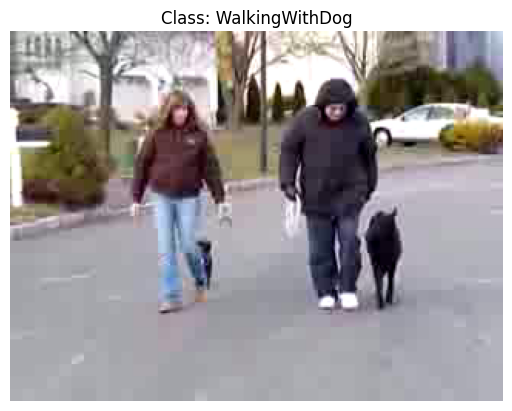

In [41]:
import matplotlib.pyplot as plt

video_path, label = dataset.samples[0]
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
plt.title(f"Class: {CLASSES[label]}")
plt.axis('off')
plt.show()
